In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Librerías estándar
import math

# Librerías de terceros: manejo de datos y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración para Matplotlib
plt.rcParams['figure.figsize'] = [25, 8]

# Librerías de terceros: machine learning y métricas
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Librerías de terceros: series de tiempo y clustering
from tslearn.clustering import silhouette_score, TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Importaciones específicas del proyecto
from lightweight_clustered_energy_forecasts.utils.paths import data_dir


c:\Users\ASUS TUF\.conda\envs\lightweight_clustered_energy_forecasts\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Funciones auxiliares

In [3]:
def nan_counter(list_of_dataframes):
    nan_polluted_series_counter = 0
    for dataframe in list_of_dataframes:
        if dataframe.isna().any().any():  # Verifica si hay NaN en cualquier columna
            nan_polluted_series_counter += 1
    print(nan_polluted_series_counter)


## Procesing data

In [4]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [5]:
building_11a=building_11a.resample("h").sum()

In [6]:
#realizamos una lista de arrays cada array correspondiendo a 1 dia de datos con frecuencia de muestreo por 15 minutos
# Agrupar por día
df=building_11a.copy()
# Agrupar por día y guardar los DataFrames en una lista
list_of_dataframes = [group for _, group in df.groupby(df.index.date)]

# Imprimir el resultado
for i, daily_df in enumerate(list_of_dataframes):
    print(f"Día {i+1}:")
    print(daily_df)
    print("-" * 50)


Día 1:
                             kwh
timestamp                       
2023-01-01 00:00:00+00:00  54.90
2023-01-01 01:00:00+00:00  53.81
2023-01-01 02:00:00+00:00  52.92
2023-01-01 03:00:00+00:00  55.99
2023-01-01 04:00:00+00:00  57.55
2023-01-01 05:00:00+00:00  53.89
2023-01-01 06:00:00+00:00  52.87
2023-01-01 07:00:00+00:00  46.73
2023-01-01 08:00:00+00:00  51.08
2023-01-01 09:00:00+00:00  55.15
2023-01-01 10:00:00+00:00  51.41
2023-01-01 11:00:00+00:00  57.62
2023-01-01 12:00:00+00:00  56.59
2023-01-01 13:00:00+00:00  59.29
2023-01-01 14:00:00+00:00  61.22
2023-01-01 15:00:00+00:00  60.16
2023-01-01 16:00:00+00:00  57.73
2023-01-01 17:00:00+00:00  59.19
2023-01-01 18:00:00+00:00  61.27
2023-01-01 19:00:00+00:00  65.10
2023-01-01 20:00:00+00:00  57.67
2023-01-01 21:00:00+00:00  58.05
2023-01-01 22:00:00+00:00  59.79
2023-01-01 23:00:00+00:00  60.30
--------------------------------------------------
Día 2:
                             kwh
timestamp                       
2023-01-02 

In [7]:
nan_counter(list_of_dataframes)

0


In [8]:
len(list_of_dataframes)

365

<Axes: xlabel='timestamp'>

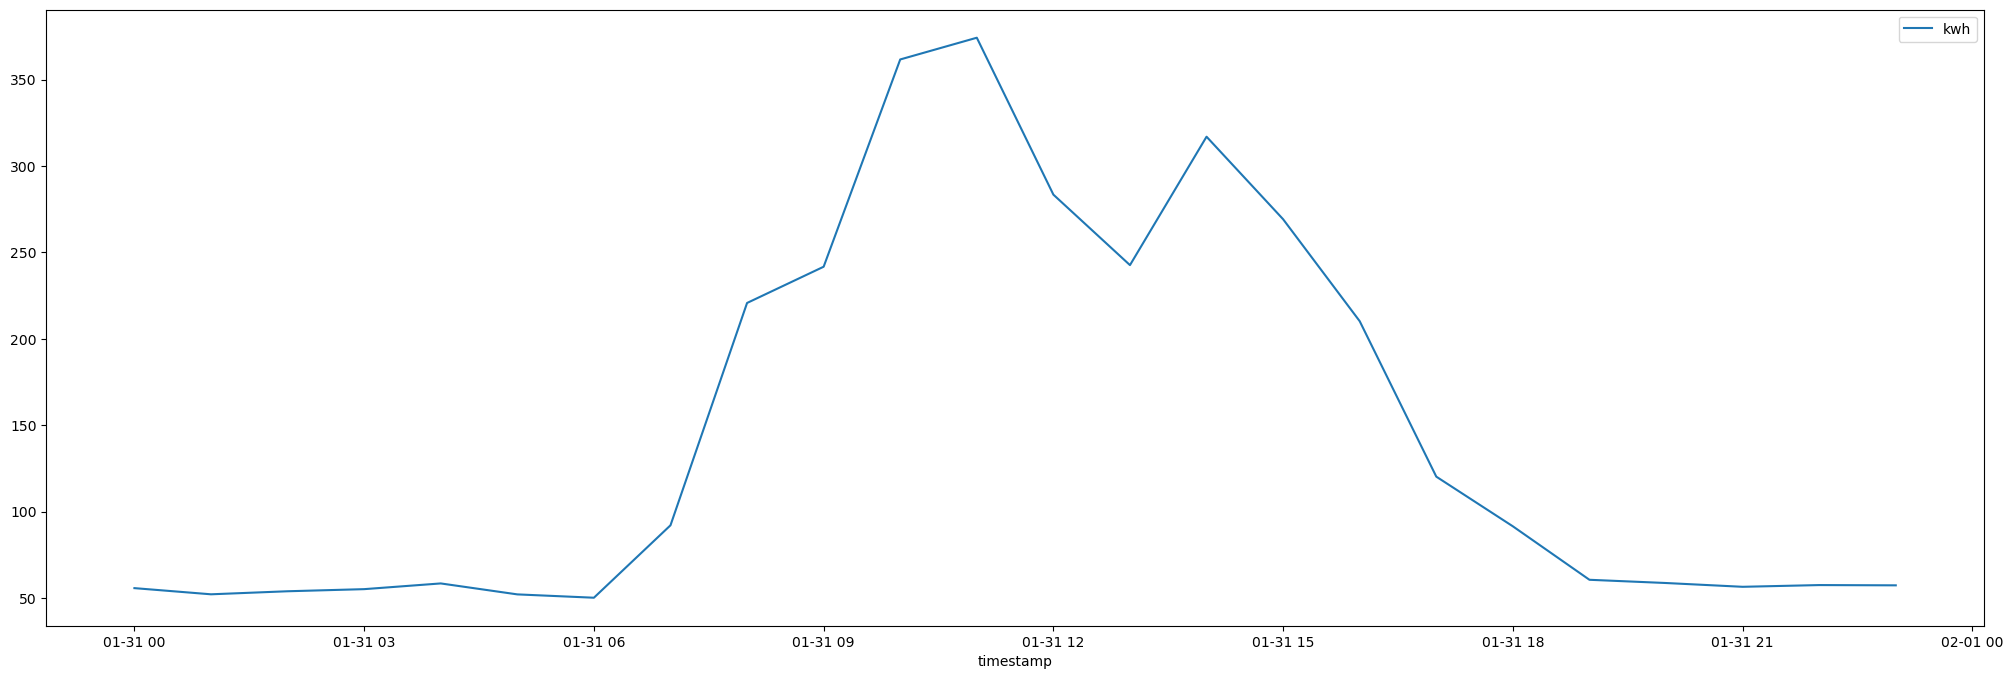

In [9]:
sns.lineplot(list_of_dataframes[30])

## clustering

Después de gestionar los valores faltantes, el otro problema es la escala de la serie. Sin la normalización de los datos, las series que se parecen entre sí se verán muy diferentes entre sí y afectarán la precisión del proceso de agrupamiento. Podemos ver el efecto de la normalización en las siguientes imágenes.

In [10]:
normalized_list_of_dataframes = []

for daily_df in list_of_dataframes:
    scaler = MinMaxScaler()
    # Normalizar cada día por separado
    normalized_daily_df = scaler.fit_transform(daily_df.values.reshape(-1, 1))  # Reshape para ajustarse a la entrada del scaler
    normalized_list_of_dataframes.append(normalized_daily_df.flatten())  # Volver a la forma 1D


El resultado del proceso de normalización parece bueno.

In [11]:
print("max: "+str(max(normalized_list_of_dataframes[0]))+"\tmin: "+str(min(normalized_list_of_dataframes[0])))
print(normalized_list_of_dataframes[0][:5])

max: 1.0	min: 0.0
[0.44474687 0.385411   0.33696244 0.50408274 0.58900381]


## kmeans

In [12]:
# Definir el rango de k para probar
K = range(2, 8)
Sum_of_squared_distances = []
Silhouette_Scores = []

# Probar con diferentes valores de k
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",  # Usamos DTW como métrica de distancia
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
    
    # Ajustar el modelo a los datos
    km = km.fit(normalized_list_of_dataframes)
    
    # Almacenar la inercia para este valor de k
    Sum_of_squared_distances.append(km.inertia_)
    silhouette = silhouette_score(normalized_list_of_dataframes, km.labels_)
    Silhouette_Scores.append(silhouette)

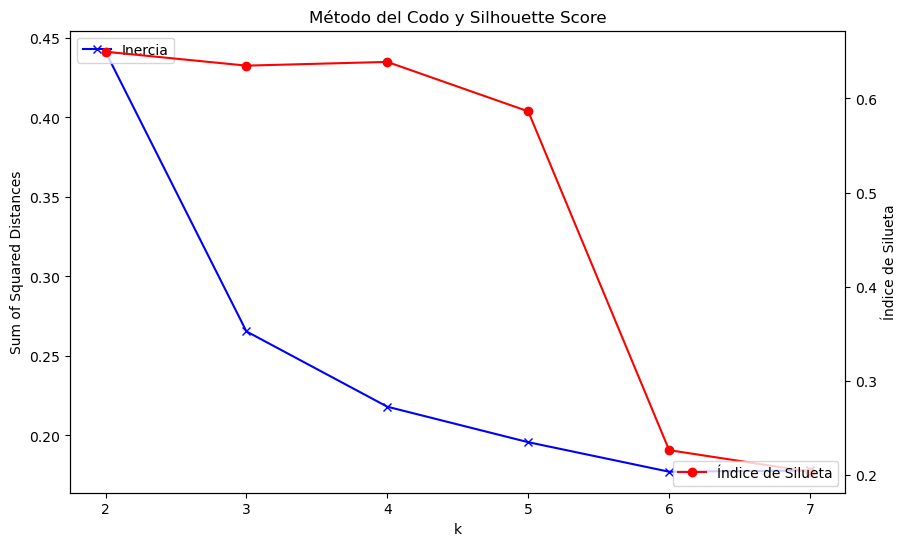

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico del codo (inercia)
ax1.plot(K, Sum_of_squared_distances, 'bx-', label="Inercia")
ax1.set_xlabel('k')
ax1.set_ylabel('Sum of Squared Distances')
ax1.set_title('Método del Codo y Silhouette Score')

# Crear un segundo eje y para el índice de silueta
ax2 = ax1.twinx()
ax2.plot(K, Silhouette_Scores, 'ro-', label="Índice de Silueta")
ax2.set_ylabel('Índice de Silueta')

# Mostrar la leyenda
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

In [14]:
Sum_of_squared_distances

[np.float64(0.44130106822624143),
 np.float64(0.2654060092499969),
 np.float64(0.21803211406482984),
 np.float64(0.19572773501533122),
 np.float64(0.17714936074504653),
 np.float64(0.17794310812958056)]

## Training  kmeans 

usando distancia Euclidiana

In [15]:
# Aplicar el clustering con el número óptimo de clusters
optimal_k = 4
km = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", verbose=False)

# Ajustar el modelo y predecir las etiquetas de los clusters
labels = km.fit_predict(normalized_list_of_dataframes)

# Mostrar las primeras etiquetas de los clusters
print("Etiquetas de los clusters para las primeras series:", labels[:5])


Etiquetas de los clusters para las primeras series: [3 3 0 0 0]


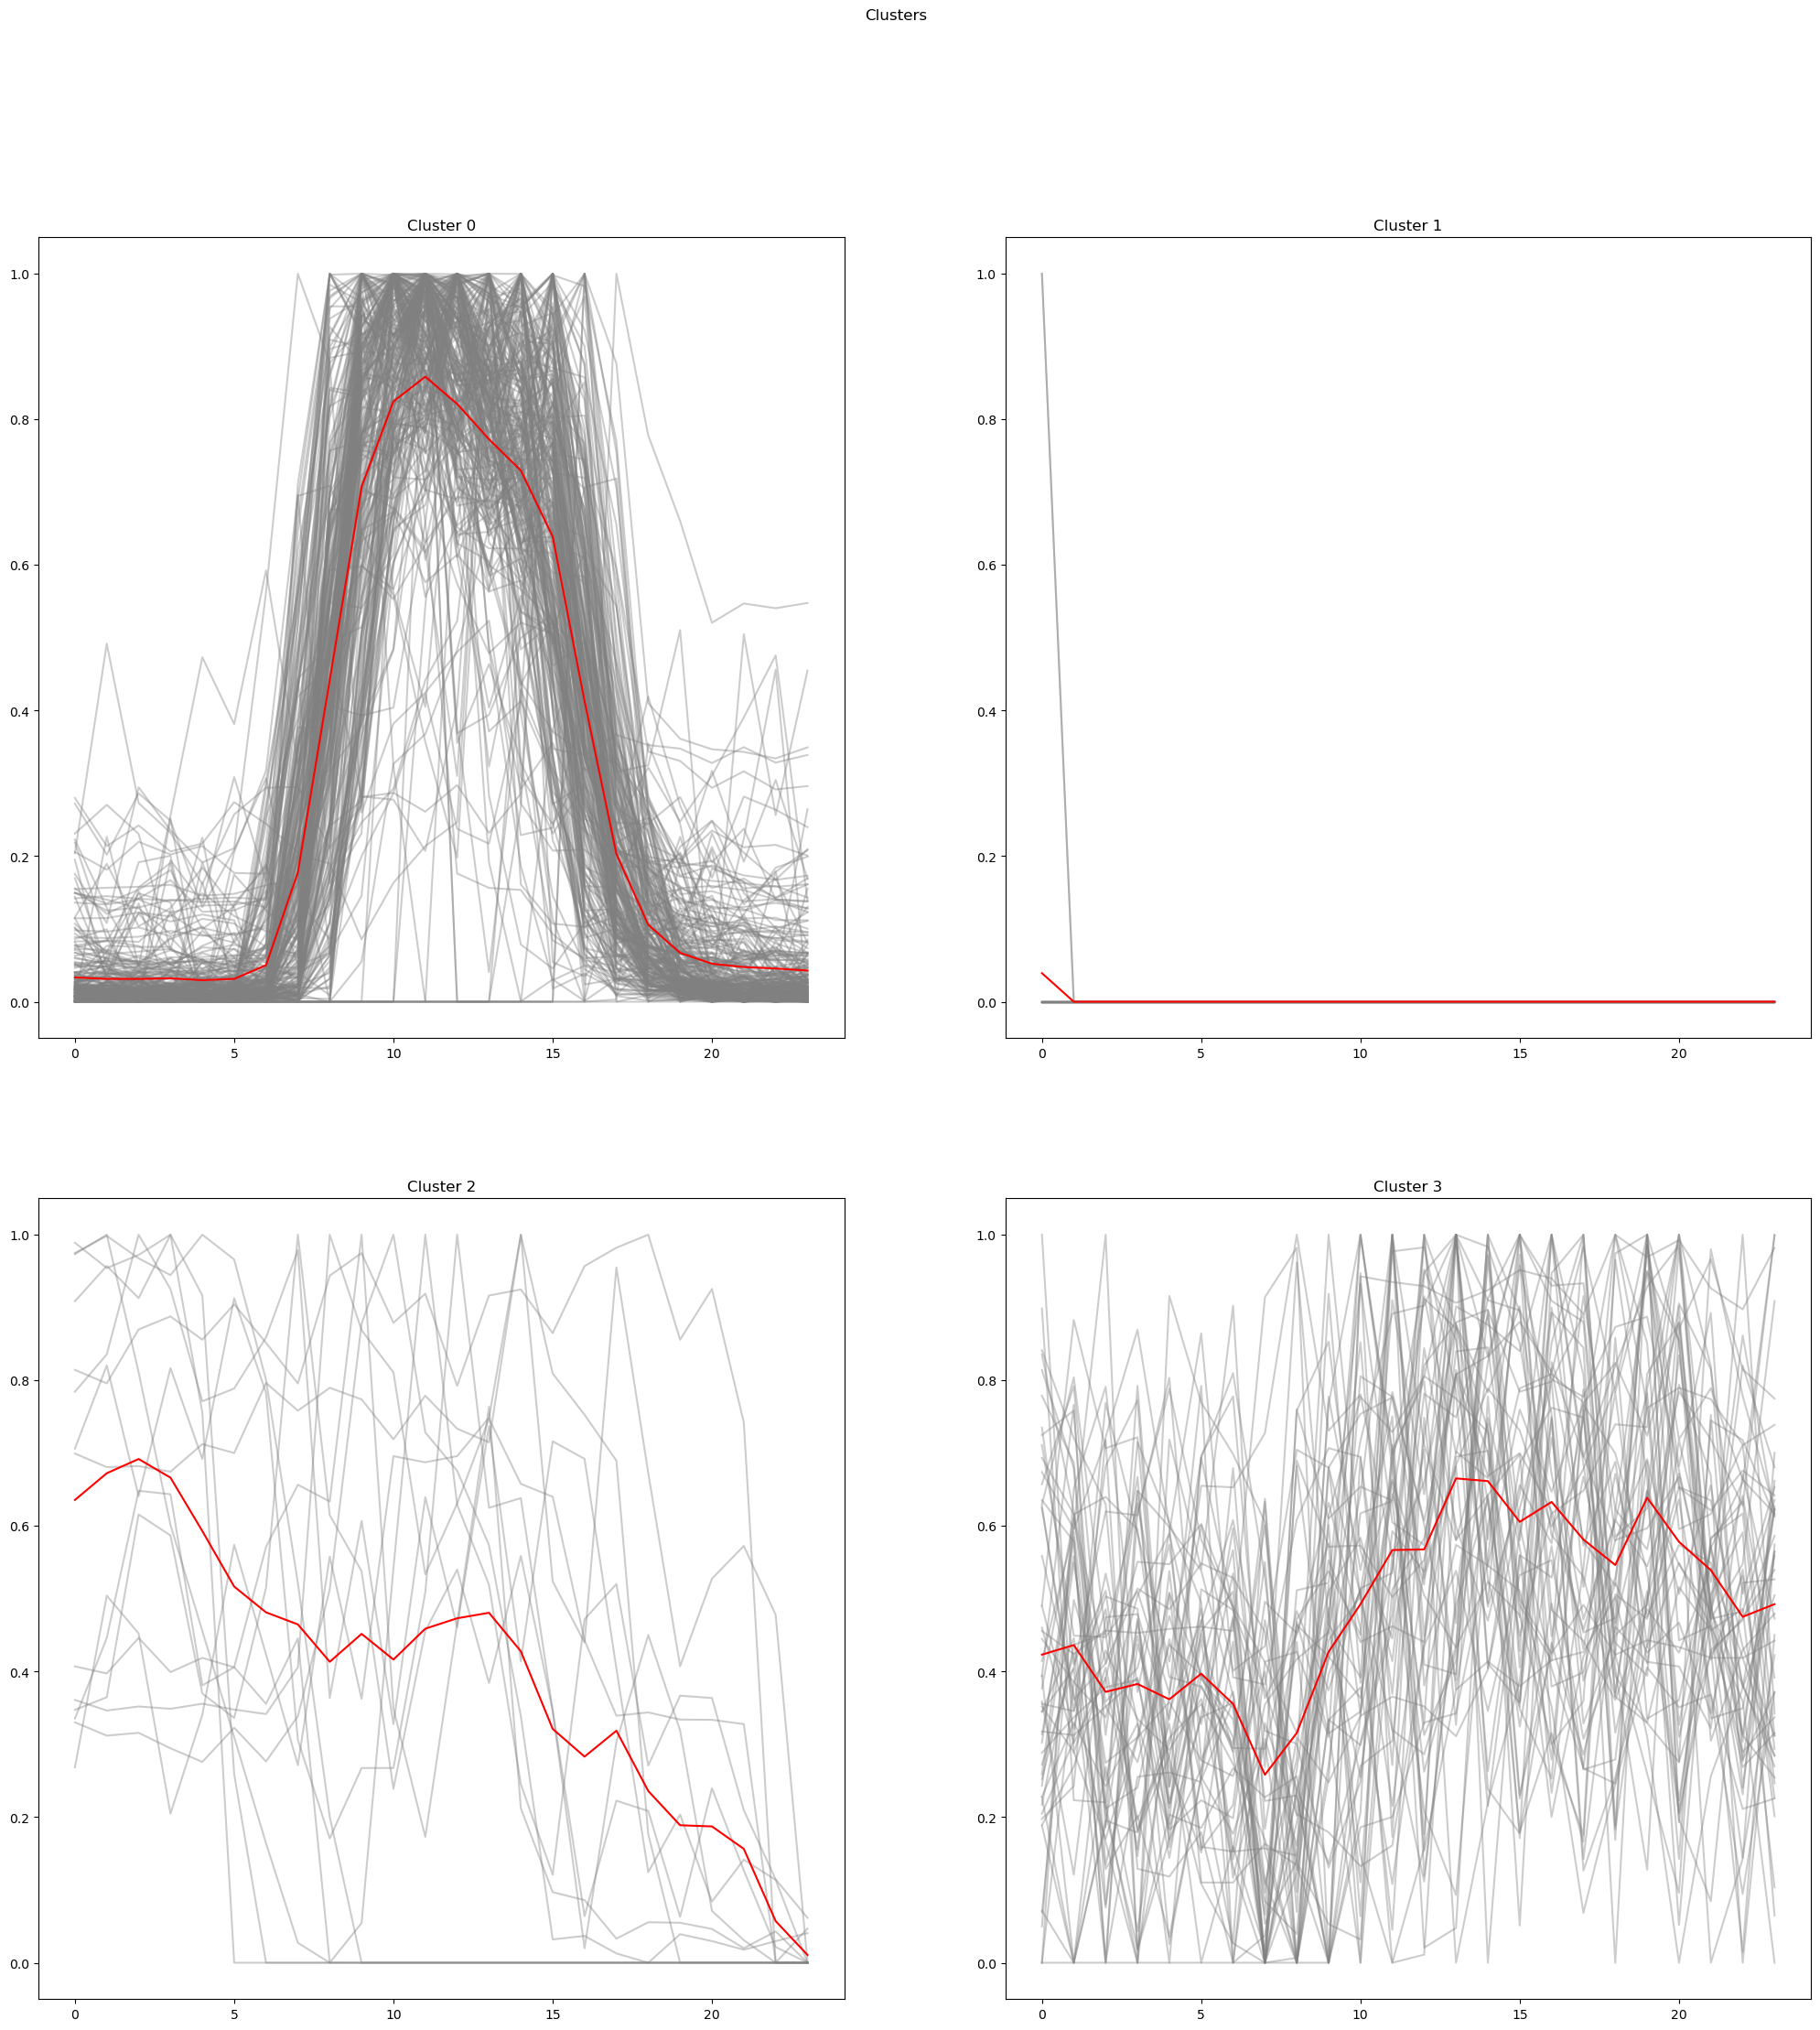

In [16]:
# Número de subgráficas
plot_count = math.ceil(math.sqrt(optimal_k))

# Crear una figura para los gráficos
fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle('Clusters')

row_i = 0
column_j = 0

# Para cada etiqueta de cluster, trazamos las series de tiempo y su promedio
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            axs[row_i, column_j].plot(normalized_list_of_dataframes[i], c="gray", alpha=0.4)
            cluster.append(normalized_list_of_dataframes[i])
    
    # Si el cluster tiene series, trazamos su promedio
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster), axis=0), c="red")
    
    axs[row_i, column_j].set_title(f"Cluster {label}")
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

# Mostrar el gráfico
plt.show()

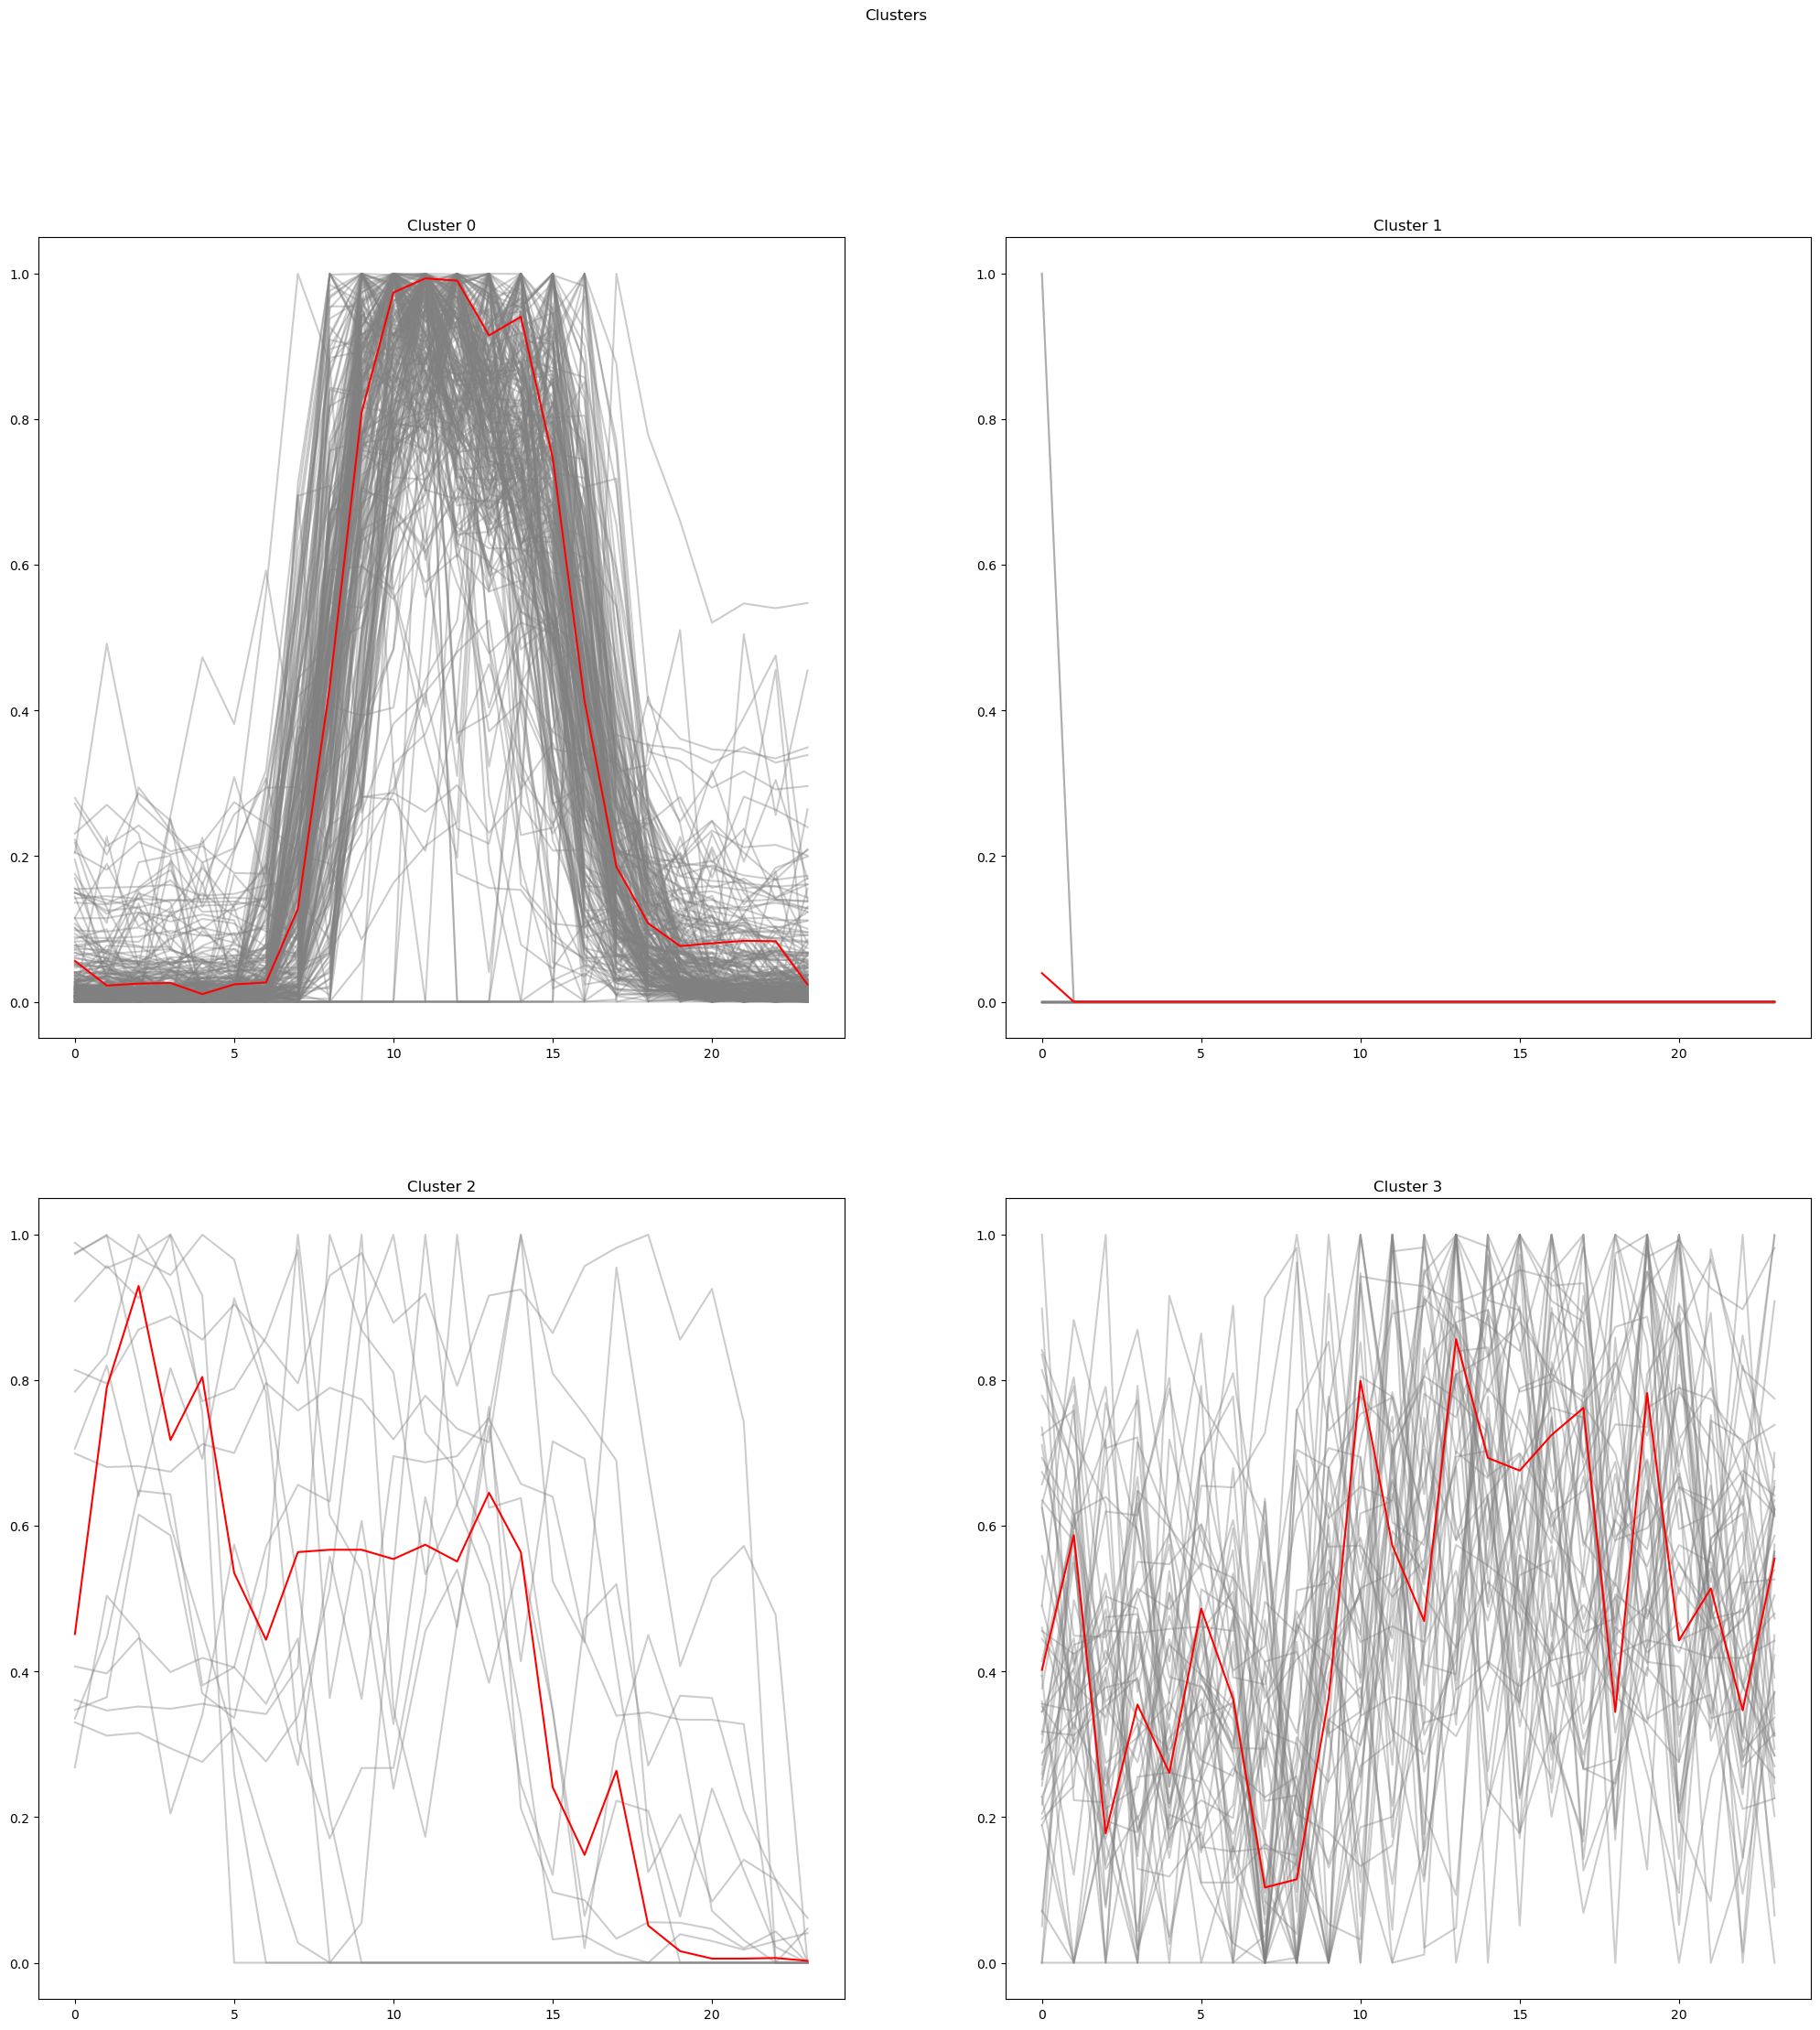

In [17]:
from tslearn.barycenters import dtw_barycenter_averaging

# Número de subgráficas
plot_count = math.ceil(math.sqrt(optimal_k))

# Crear una figura para los gráficos
fig, axs = plt.subplots(plot_count, plot_count, figsize=(25, 25))
fig.suptitle('Clusters')

row_i = 0
column_j = 0

# Para cada etiqueta de cluster, trazamos las series de tiempo y su promedio
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
        if labels[i] == label:
            axs[row_i, column_j].plot(normalized_list_of_dataframes[i], c="gray", alpha=0.4)
            cluster.append(normalized_list_of_dataframes[i])
    
    # Si el cluster tiene series, trazamos su promedio
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)), c="red")
    
    axs[row_i, column_j].set_title(f"Cluster {label}")
    column_j += 1
    if column_j % plot_count == 0:
        row_i += 1
        column_j = 0

# Mostrar el gráfico
plt.show()

Cantidad de series en cada cluster: [np.int64(248), np.int64(51), np.int64(14), np.int64(52)]


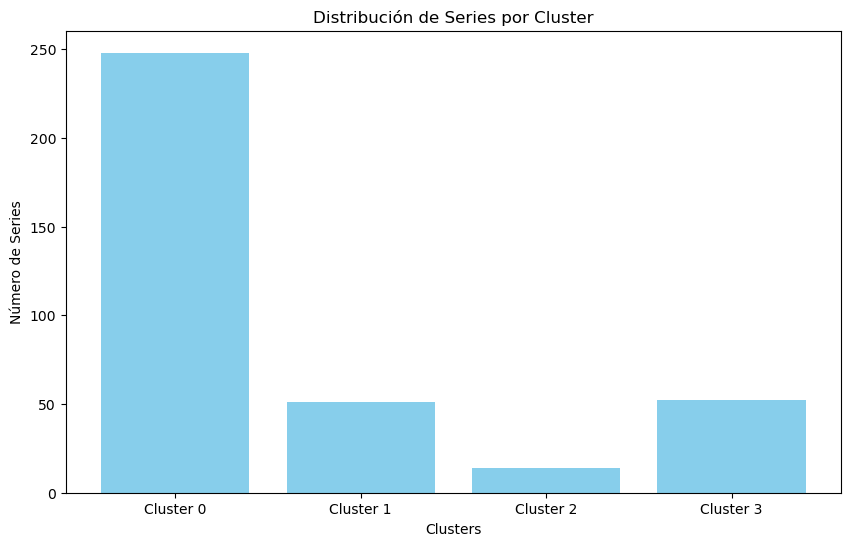

In [18]:
# Contar cuántas series pertenecen a cada cluster
cluster_counts = [np.sum(labels == i) for i in range(optimal_k)]

# Mostrar la cantidad de series en cada cluster
print("Cantidad de series en cada cluster:", cluster_counts)

# Etiquetas para los clusters
cluster_labels = [f"Cluster {i}" for i in range(optimal_k)]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(cluster_labels, cluster_counts, color='skyblue')
plt.title("Distribución de Series por Cluster")
plt.xlabel("Clusters")
plt.ylabel("Número de Series")
plt.show()


In [19]:
# Crear una lista vacía para almacenar las fechas y las etiquetas de los clusters
dates = []
cluster_labels = []

# Recorrer las series de tiempo, y asignar las fechas y las etiquetas correspondientes
for i, daily_df in enumerate(list_of_dataframes):
    current_dates = daily_df.index  # Obtener las fechas de este día
    dates.extend(current_dates)  # Añadir las fechas
    cluster_labels.extend([labels[i]] * len(current_dates))  # Añadir la etiqueta del cluster para cada fecha

# Crear un DataFrame con las fechas y las etiquetas de los clusters
df_clusters = pd.DataFrame({
    'Date': dates,
    'Cluster': cluster_labels
})

# Ver las primeras filas para verificar
df_clusters.head()


Date  Cluster
0 2023-01-01 00:00:00+00:00        3
1 2023-01-01 01:00:00+00:00        3
2 2023-01-01 02:00:00+00:00        3
3 2023-01-01 03:00:00+00:00        3
4 2023-01-01 04:00:00+00:00        3

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_10408\661334166.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_distribution = df_clusters.groupby(['Cluster', 'Weekday']).size().unstack(fill_value=0)


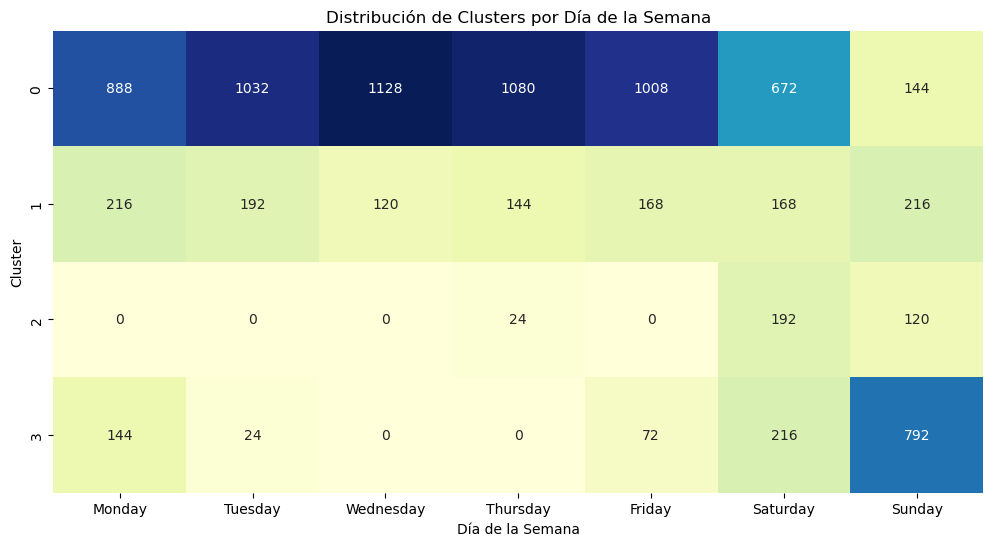

In [20]:
# Definir el orden correcto de los días de la semana
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_dtype = pd.CategoricalDtype(categories=weekday_order, ordered=True)
df_clusters['Weekday'] = pd.to_datetime(df_clusters['Date']).dt.day_name()
# Convertir la columna 'Weekday' en una categoría ordenada
df_clusters['Weekday'] = df_clusters['Weekday'].astype(weekday_dtype)
df_clusters=df_clusters.sort_values(by="Weekday")
# Agrupar por cluster y día de la semana
weekday_distribution = df_clusters.groupby(['Cluster', 'Weekday']).size().unstack(fill_value=0)

import seaborn as sns

# Mostrar la distribución por día de la semana
plt.figure(figsize=(12, 6))
sns.heatmap(weekday_distribution, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title('Distribución de Clusters por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cluster')
plt.show()


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_10408\3457593411.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_distribution = df_clusters.groupby(['Cluster', 'Month']).size().unstack(fill_value=0)


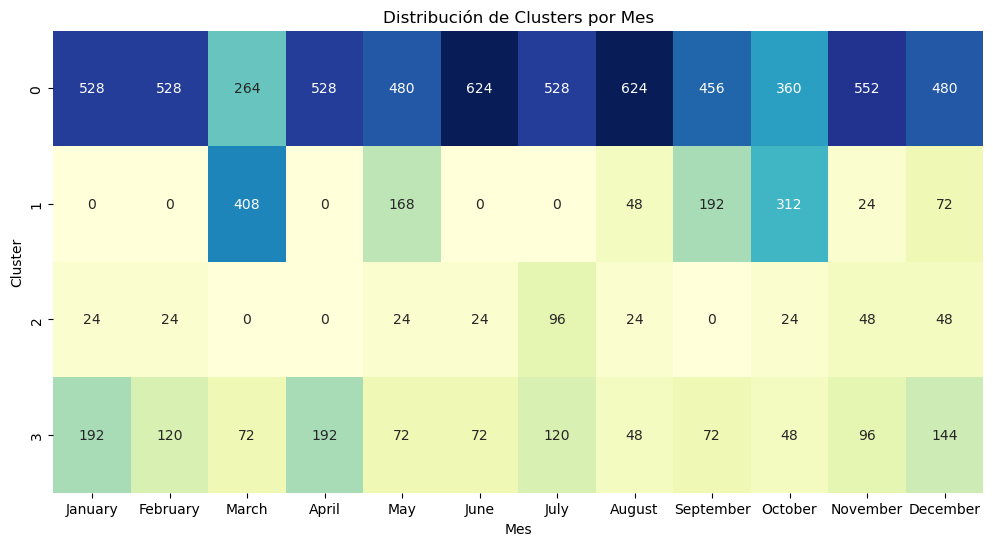

In [21]:
# Definir el orden correcto de los meses del año
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_dtype = pd.CategoricalDtype(categories=month_order, ordered=True)
df_clusters['Month'] = pd.to_datetime(df_clusters['Date']).dt.month_name()
# Convertir la columna 'Month' en una categoría ordenada
df_clusters['Month'] = df_clusters['Month'].astype(month_dtype)
df_clusters=df_clusters.sort_values(by="Month")

# Agrupar por cluster y mes
month_distribution = df_clusters.groupby(['Cluster', 'Month']).size().unstack(fill_value=0)

# Mostrar la distribución por mes
plt.figure(figsize=(12, 6))
sns.heatmap(month_distribution, annot=True, cmap="YlGnBu", fmt='d', cbar=False)
plt.title('Distribución de Clusters por Mes')
plt.xlabel('Mes')
plt.ylabel('Cluster')
plt.show()


## Forecasting

In [94]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [95]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [96]:
def add_lags(df):
    target_map = df['kwh'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    return df

In [97]:
def smape(y_true, y_pred):
  numerator = np.abs(y_true - y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  ratio = numerator / denominator
  return ratio.mean()

In [98]:
train = building_11a.loc[building_11a.index < '2023-12-24']
test = building_11a.loc[building_11a.index >= '2023-12-24']

In [99]:
train =create_features(train)
train =add_lags(train)
test =create_features(test)
test =add_lags(test)

In [100]:
def entrenamiento_modelo(cluster,data,data_cluster):
    # Filtrar las series del cluster actual
    data_cluster=data_cluster.sort_index()
    data=data.sort_index()
    cluster_dates = data_cluster[data_cluster['Cluster'] == cluster]['Date']

    cluster_data_train = data[data.index.isin(cluster_dates)]
    cluster_data_train=cluster_data_train.sort_index()
    # Separar las características (X) y el target (y)
    X_train_cluster = cluster_data_train.drop(columns=['kwh'])
    y_train_cluster = cluster_data_train['kwh']
    
    # Inicializar y entrenar el modelo XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train_cluster, y_train_cluster)
    # Evaluación en el conjunto de entrenamiento
    y_train_pred = model.predict(X_train_cluster)
    cluster_data_train['predictions'] = y_train_pred
    cluster_data_train=cluster_data_train.reset_index()
    predict_df=cluster_data_train.loc[:,["timestamp","kwh","predictions"]]
    return model,predict_df

In [101]:
def inference_models(cluster,data,data_cluster,models):
    data_cluster=data_cluster.sort_index()
    data=data.sort_index()
    cluster_dates = data_cluster[data_cluster['Cluster'] == cluster]['Date']
    cluster_data_infer = data[data.index.isin(cluster_dates)]
    cluster_data_infer=cluster_data_infer.sort_index()
    model=models[f"{cluster}"]
    if not cluster_data_infer.empty:
        X_infer = cluster_data_infer.drop(columns=['kwh'])
        y_test_pred = model.predict(X_infer)
        cluster_data_infer['predictions'] = y_test_pred
        cluster_data_infer=cluster_data_infer.reset_index()
        predict_df=cluster_data_infer.loc[:,["timestamp","kwh","predictions"]]
    else:
        print(f"No hay datos en el testeo para el Cluster {cluster}")
        predict_df=pd.DataFrame()
    return predict_df

In [102]:
models = {}
train_results =pd.DataFrame()
test_results = pd.DataFrame()
for cluster in df_clusters['Cluster'].unique():
    print(f"\nEntrenando modelo para el Cluster {cluster}...")
    modelo,prediction_train=entrenamiento_modelo(cluster,train,df_clusters)
    models[f"{cluster}"]=modelo
    train_results=pd.concat([train_results, prediction_train], ignore_index=True)
    inference=inference_models(cluster,test,df_clusters,models)
    test_results=pd.concat([test_results, inference], ignore_index=True)
train_results=train_results.sort_values(by="timestamp")
test_results=test_results.sort_values(by="timestamp")


Entrenando modelo para el Cluster 0...

Entrenando modelo para el Cluster 3...

Entrenando modelo para el Cluster 2...

Entrenando modelo para el Cluster 1...
No hay datos en el testeo para el Cluster 1


In [103]:
mse = np.sqrt(mean_squared_error(test_results["kwh"], test_results["predictions"]))

smape_score=smape(test_results["kwh"], test_results["predictions"])
# Mostrar resultados finales
print("\nResultados :")
print("mae:", mse)
print("smape:", smape_score)


Resultados :
mae: 99.96401510042193
smape: 0.4263034444739311


In [104]:
test_results.head()

timestamp    kwh  predictions
96  2023-12-24 00:00:00+00:00  67.19    61.615864
97  2023-12-24 01:00:00+00:00  65.34    62.008282
98  2023-12-24 02:00:00+00:00  63.36    63.016743
99  2023-12-24 03:00:00+00:00  61.74    63.016743
100 2023-12-24 04:00:00+00:00  65.35    63.016743

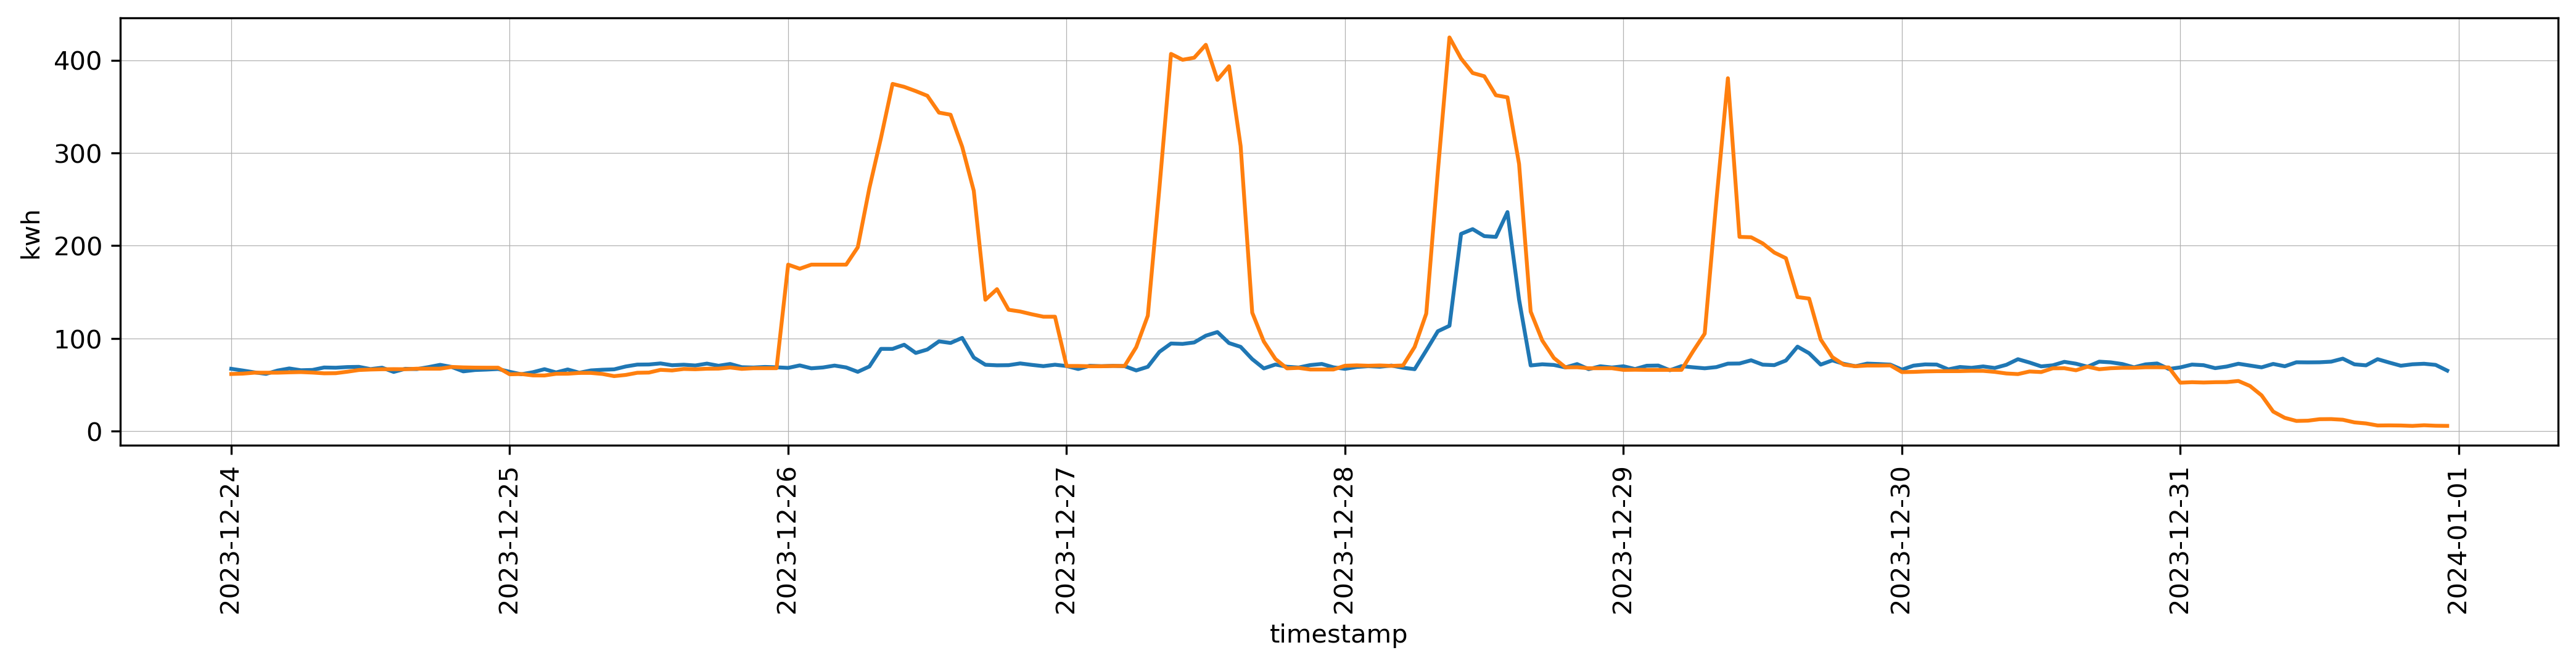

In [105]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_results, x='timestamp', y='kwh')
sns.lineplot(data=test_results, x='timestamp', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

## Tunning models

In [158]:
train = building_11a.loc[building_11a.index < '2023-12-24']
test = building_11a.loc[building_11a.index >= '2023-12-24']

In [159]:
train =create_features(train)
train =add_lags(train)
test =create_features(test)
test =add_lags(test)

## Tunning model cluster 0

In [117]:
models={}

In [118]:
data=train.sort_index()
cluster_dates = df_clusters[df_clusters['Cluster'] == 0]['Date']

cluster_data_train = data[data.index.isin(cluster_dates)]
cluster_data_train=cluster_data_train.sort_index()

In [119]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*7, gap=12)
df = cluster_data_train.sort_index()

fold = 0
preds = []
scores = []
scores_smape=[]
for train_idx, val_idx in tss.split(df):
    df =create_features(df)
    df=add_lags(df)

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
#    train =create_features(train)
#    train=add_lags(train)
#    test =create_features(test)
#    test=add_lags(test)
    TARGET = 'kwh'

    X_train = train.drop(columns=[TARGET])
    y_train = train[TARGET]

    X_test = test.drop(columns=[TARGET])
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01,eval_metric='mae')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)

[0]	validation_0-mae:160.19921	validation_1-mae:194.56017
[100]	validation_0-mae:67.90073	validation_1-mae:88.24816
[200]	validation_0-mae:46.52049	validation_1-mae:59.46936
[300]	validation_0-mae:42.07726	validation_1-mae:47.94538
[400]	validation_0-mae:40.26497	validation_1-mae:46.65246
[433]	validation_0-mae:39.82464	validation_1-mae:46.88890
[0]	validation_0-mae:161.51377	validation_1-mae:184.78715
[100]	validation_0-mae:67.74915	validation_1-mae:72.21526
[200]	validation_0-mae:46.78186	validation_1-mae:40.81539
[300]	validation_0-mae:42.39443	validation_1-mae:35.31468
[400]	validation_0-mae:40.38909	validation_1-mae:33.47846
[500]	validation_0-mae:39.10541	validation_1-mae:33.03494
[549]	validation_0-mae:38.68360	validation_1-mae:33.32971
[0]	validation_0-mae:162.23356	validation_1-mae:189.33018
[100]	validation_0-mae:67.78443	validation_1-mae:96.96878
[200]	validation_0-mae:46.50790	validation_1-mae:73.75922
[300]	validation_0-mae:41.91863	validation_1-mae:65.01395
[400]	validati

In [120]:
X_train, y_train =cluster_data_train.drop(columns=["kwh"]),cluster_data_train["kwh"]

In [121]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 350, 400],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Usamos RMSE como métrica
    cv=3
)
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, así que lo multiplicamos por -1)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Mostrar los resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])



Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
Mejor puntuación de validación (RMSE): 80.80520870506253
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 300       -82.050176   
1                 3                 0.01                 350       -81.290107   
2                 3                 0.01                 400       -80.805209   
3                 5                 0.01                 300       -84.454128   
4                 5                 0.01                 350       -85.053953   
5                 5                 0.01                 400       -86.348846   
6                 7                 0.01                 300       -88.156436   
7                 7                 0.01                 350       -88.301873   
8                 7                 0.01                 400       -88.501411   
9                 3                 0.05

In [122]:
# Entrenar el modelo
reg_0 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=400,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [123]:
reg_0.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [124]:
models["0"]=reg_0

## Tunning model cluster 1

In [127]:
data=train.sort_index()
cluster_dates = df_clusters[df_clusters['Cluster'] == 1]['Date']

cluster_data_train = data[data.index.isin(cluster_dates)]
cluster_data_train=cluster_data_train.sort_index()

In [128]:
cluster_data_train

kwh  hour  dayofweek  quarter  month  dayofyear  \
timestamp                                                                      
2023-03-09 00:00:00+00:00  13.58     0          3        1      3         68   
2023-03-09 01:00:00+00:00   0.00     1          3        1      3         68   
2023-03-09 02:00:00+00:00   0.00     2          3        1      3         68   
2023-03-09 03:00:00+00:00   0.00     3          3        1      3         68   
2023-03-09 04:00:00+00:00   0.00     4          3        1      3         68   
...                          ...   ...        ...      ...    ...        ...   
2023-12-12 19:00:00+00:00   0.00    19          1        4     12        346   
2023-12-12 20:00:00+00:00   0.00    20          1        4     12        346   
2023-12-12 21:00:00+00:00   0.00    21          1        4     12        346   
2023-12-12 22:00:00+00:00   0.00    22          1        4     12        346   
2023-12-12 23:00:00+00:00   0.00    23          1        4     12        346   

                           dayofmonth  weekofyear   lag1   lag2   lag3  
timestamp                                                               
2023-03-09 00:00:00+00:00           9          10  55.58  49.80  68.91  
2023-03-09 01:00:00+00:00           9          10  51.83  50.28  70.85  
2023-03-09 02:00:00+00:00           9          10  51.58  49.35  70.23  
2023-03-09 03:00:00+00:00           9          10  52.85  53.05  80.13  
2023-03-09 04:00:00+00:00           9          10  49.59  52.76  72.78  
...                               ...         ...    ...    ...    ...  
2023-12-12 19:00:00+00:00          12          50   0.00   0.00  63.28  
2023-12-12 20:00:00+00:00          12          50   0.00   0.00  66.11  
2023-12-12 21:00:00+00:00          12          50   0.00   0.00  64.50  
2023-12-12 22:00:00+00:00          12          50   0.00   0.00  62.66  
2023-12-12 23:00:00+00:00          12          50   0.00   0.00  62.11  

[1224 rows x 11 columns]

In [129]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*7, gap=12)
df = cluster_data_train.sort_index()

fold = 0
preds = []
scores = []
scores_smape=[]
for train_idx, val_idx in tss.split(df):
    df =create_features(df)
    df=add_lags(df)

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
#    train =create_features(train)
#    train=add_lags(train)
#    test =create_features(test)
#    test=add_lags(test)
    TARGET = 'kwh'

    X_train = train.drop(columns=[TARGET])
    y_train = train[TARGET]

    X_test = test.drop(columns=[TARGET])
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01,eval_metric='mae')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)

[0]	validation_0-mae:0.52868	validation_1-mae:0.49503
[100]	validation_0-mae:0.20287	validation_1-mae:0.18218
[200]	validation_0-mae:0.07970	validation_1-mae:0.06706
[300]	validation_0-mae:0.03239	validation_1-mae:0.02469
[400]	validation_0-mae:0.01377	validation_1-mae:0.00909
[500]	validation_0-mae:0.00619	validation_1-mae:0.00335
[600]	validation_0-mae:0.00296	validation_1-mae:0.00123
[700]	validation_0-mae:0.00150	validation_1-mae:0.00045
[800]	validation_0-mae:0.00080	validation_1-mae:0.00017
[900]	validation_0-mae:0.00045	validation_1-mae:0.00006
[999]	validation_0-mae:0.00026	validation_1-mae:0.00002
[0]	validation_0-mae:0.51820	validation_1-mae:0.64994
[100]	validation_0-mae:0.19613	validation_1-mae:0.34042
[200]	validation_0-mae:0.07554	validation_1-mae:0.22665
[300]	validation_0-mae:0.02987	validation_1-mae:0.18492
[400]	validation_0-mae:0.01227	validation_1-mae:0.16967
[500]	validation_0-mae:0.00529	validation_1-mae:0.16405
[600]	validation_0-mae:0.00241	validation_1-mae:0.16

In [130]:
X_train, y_train =cluster_data_train.drop(columns=["kwh"]),cluster_data_train["kwh"]

In [131]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [350, 400, 500],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Usamos RMSE como métrica
    cv=3
)
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, así que lo multiplicamos por -1)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Mostrar los resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 350}
Mejor puntuación de validación (RMSE): 1.2742418116587153
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 350        -1.274242   
1                 3                 0.01                 400        -1.303828   
2                 3                 0.01                 500        -1.344788   
3                 5                 0.01                 350        -1.274242   
4                 5                 0.01                 400        -1.303828   
5                 5                 0.01                 500        -1.344788   
6                 7                 0.01                 350        -1.274242   
7                 7                 0.01                 400        -1.303828   
8                 7                 0.01                 500        -1.344788   
9                 3                 0.0

In [132]:
# Entrenar el modelo
reg_1 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=350,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [133]:
reg_1.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [134]:
models["1"]=reg_1

## Tunning model cluster 2

In [137]:
data=train.sort_index()
cluster_dates = df_clusters[df_clusters['Cluster'] == 2]['Date']

cluster_data_train = data[data.index.isin(cluster_dates)]
cluster_data_train=cluster_data_train.sort_index()

In [138]:
cluster_data_train

kwh  hour  dayofweek  quarter  month  dayofyear  \
timestamp                                                                      
2023-01-29 00:00:00+00:00  53.70     0          6        1      1         29   
2023-01-29 01:00:00+00:00  52.47     1          6        1      1         29   
2023-01-29 02:00:00+00:00  57.36     2          6        1      1         29   
2023-01-29 03:00:00+00:00  58.54     3          6        1      1         29   
2023-01-29 04:00:00+00:00  56.43     4          6        1      1         29   
...                          ...   ...        ...      ...    ...        ...   
2023-12-10 19:00:00+00:00   0.00    19          6        4     12        344   
2023-12-10 20:00:00+00:00   0.00    20          6        4     12        344   
2023-12-10 21:00:00+00:00   0.00    21          6        4     12        344   
2023-12-10 22:00:00+00:00   0.00    22          6        4     12        344   
2023-12-10 23:00:00+00:00   0.00    23          6        4     12        344   

                           dayofmonth  weekofyear   lag1   lag2   lag3  
timestamp                                                               
2023-01-29 00:00:00+00:00          29           4  53.29  56.57  60.24  
2023-01-29 01:00:00+00:00          29           4  54.55  58.99  52.32  
2023-01-29 02:00:00+00:00          29           4  60.40  55.70  56.95  
2023-01-29 03:00:00+00:00          29           4  58.13  55.57  52.44  
2023-01-29 04:00:00+00:00          29           4  55.92  57.27  56.21  
...                               ...         ...    ...    ...    ...  
2023-12-10 19:00:00+00:00          10          49  63.28  67.85  75.73  
2023-12-10 20:00:00+00:00          10          49  66.11  65.94  71.23  
2023-12-10 21:00:00+00:00          10          49  64.50  64.69  70.06  
2023-12-10 22:00:00+00:00          10          49  62.66  67.40  74.90  
2023-12-10 23:00:00+00:00          10          49  62.11  64.39  67.81  

[312 rows x 11 columns]

In [139]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*2, gap=12)
df = cluster_data_train.sort_index()

fold = 0
preds = []
scores = []
scores_smape=[]
for train_idx, val_idx in tss.split(df):
    df =create_features(df)
    df=add_lags(df)

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
#    train =create_features(train)
#    train=add_lags(train)
#    test =create_features(test)
#    test=add_lags(test)
    TARGET = 'kwh'

    X_train = train.drop(columns=[TARGET])
    y_train = train[TARGET]

    X_test = test.drop(columns=[TARGET])
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01,eval_metric='mae')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)

[0]	validation_0-mae:73.85110	validation_1-mae:37.14851
[100]	validation_0-mae:28.97940	validation_1-mae:30.76542
[200]	validation_0-mae:13.15561	validation_1-mae:27.25337
[300]	validation_0-mae:9.25655	validation_1-mae:26.33112
[357]	validation_0-mae:8.48498	validation_1-mae:26.71460
[0]	validation_0-mae:50.87468	validation_1-mae:61.25321
[100]	validation_0-mae:20.09945	validation_1-mae:23.98652
[200]	validation_0-mae:8.67540	validation_1-mae:12.54126
[300]	validation_0-mae:6.35090	validation_1-mae:11.26644
[349]	validation_0-mae:5.94486	validation_1-mae:11.33047
[0]	validation_0-mae:54.09157	validation_1-mae:12.68812
[50]	validation_0-mae:33.48826	validation_1-mae:20.97772
[0]	validation_0-mae:47.75007	validation_1-mae:76.74970
[100]	validation_0-mae:20.97058	validation_1-mae:64.31286
[200]	validation_0-mae:11.06086	validation_1-mae:59.22729
[300]	validation_0-mae:7.92514	validation_1-mae:53.82964
[400]	validation_0-mae:6.89623	validation_1-mae:52.17306
[500]	validation_0-mae:6.26634

In [140]:
X_train, y_train =cluster_data_train.drop(columns=["kwh"]),cluster_data_train["kwh"]

In [141]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [350, 400, 500],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Usamos RMSE como métrica
    cv=3
)
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, así que lo multiplicamos por -1)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Mostrar los resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 350}
Mejor puntuación de validación (RMSE): 51.076818070647384
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 350       -51.076818   
1                 3                 0.01                 400       -51.268725   
2                 3                 0.01                 500       -51.701047   
3                 5                 0.01                 350       -58.492996   
4                 5                 0.01                 400       -58.647284   
5                 5                 0.01                 500       -58.874829   
6                 7                 0.01                 350       -59.113754   
7                 7                 0.01                 400       -59.253506   
8                 7                 0.01                 500       -59.319241   
9                 3                 0.0

In [142]:
# Entrenar el modelo
reg_2 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=350,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [143]:
reg_2.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [144]:
models["2"]=reg_2

## Tunning model cluster 3

In [147]:
data=train.sort_index()
cluster_dates = df_clusters[df_clusters['Cluster'] == 3]['Date']

cluster_data_train = data[data.index.isin(cluster_dates)]
cluster_data_train=cluster_data_train.sort_index()

In [148]:
cluster_data_train

kwh  hour  dayofweek  quarter  month  dayofyear  \
timestamp                                                                      
2023-01-01 00:00:00+00:00  54.90     0          6        1      1          1   
2023-01-01 01:00:00+00:00  53.81     1          6        1      1          1   
2023-01-01 02:00:00+00:00  52.92     2          6        1      1          1   
2023-01-01 03:00:00+00:00  55.99     3          6        1      1          1   
2023-01-01 04:00:00+00:00  57.55     4          6        1      1          1   
...                          ...   ...        ...      ...    ...        ...   
2023-12-23 19:00:00+00:00  68.53    19          5        4     12        357   
2023-12-23 20:00:00+00:00  64.13    20          5        4     12        357   
2023-12-23 21:00:00+00:00  66.19    21          5        4     12        357   
2023-12-23 22:00:00+00:00  63.71    22          5        4     12        357   
2023-12-23 23:00:00+00:00  66.08    23          5        4     12        357   

                           dayofmonth  weekofyear   lag1   lag2   lag3  
timestamp                                                               
2023-01-01 00:00:00+00:00           1          52    NaN    NaN    NaN  
2023-01-01 01:00:00+00:00           1          52    NaN    NaN    NaN  
2023-01-01 02:00:00+00:00           1          52    NaN    NaN    NaN  
2023-01-01 03:00:00+00:00           1          52    NaN    NaN    NaN  
2023-01-01 04:00:00+00:00           1          52    NaN    NaN    NaN  
...                               ...         ...    ...    ...    ...  
2023-12-23 19:00:00+00:00          23          51  73.68  72.09  67.42  
2023-12-23 20:00:00+00:00          23          51  67.04  69.02  65.17  
2023-12-23 21:00:00+00:00          23          51  66.35  69.88  63.79  
2023-12-23 22:00:00+00:00          23          51  63.87  67.08  64.17  
2023-12-23 23:00:00+00:00          23          51  62.43  63.91  61.90  

[1176 rows x 11 columns]

In [149]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*7, gap=12)
df = cluster_data_train.sort_index()

fold = 0
preds = []
scores = []
scores_smape=[]
for train_idx, val_idx in tss.split(df):
    df =create_features(df)
    df=add_lags(df)

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
#    train =create_features(train)
#    train=add_lags(train)
#    test =create_features(test)
#    test=add_lags(test)
    TARGET = 'kwh'

    X_train = train.drop(columns=[TARGET])
    y_train = train[TARGET]

    X_test = test.drop(columns=[TARGET])
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01,eval_metric='mae')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)

[0]	validation_0-mae:54.04407	validation_1-mae:49.75475
[100]	validation_0-mae:19.98345	validation_1-mae:15.25439
[200]	validation_0-mae:7.45275	validation_1-mae:10.10013
[205]	validation_0-mae:7.10583	validation_1-mae:10.29894
[0]	validation_0-mae:53.10921	validation_1-mae:53.59892
[100]	validation_0-mae:19.84177	validation_1-mae:23.12201
[200]	validation_0-mae:7.62202	validation_1-mae:12.10843
[300]	validation_0-mae:3.67935	validation_1-mae:8.71496
[400]	validation_0-mae:2.80188	validation_1-mae:7.72842
[500]	validation_0-mae:2.57098	validation_1-mae:7.43170
[600]	validation_0-mae:2.47173	validation_1-mae:7.38937
[638]	validation_0-mae:2.44169	validation_1-mae:7.40076
[0]	validation_0-mae:53.16496	validation_1-mae:52.13286
[100]	validation_0-mae:19.92426	validation_1-mae:18.84653
[200]	validation_0-mae:7.63201	validation_1-mae:7.46000
[300]	validation_0-mae:3.85331	validation_1-mae:5.67541
[400]	validation_0-mae:3.00210	validation_1-mae:5.59344
[412]	validation_0-mae:2.96179	validati

In [150]:
X_train, y_train =cluster_data_train.drop(columns=["kwh"]),cluster_data_train["kwh"]

In [151]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [350, 400, 500],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Usamos RMSE como métrica
    cv=3
)
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, así que lo multiplicamos por -1)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Mostrar los resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])


Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 350}
Mejor puntuación de validación (RMSE): 12.73329770147167
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 350       -13.340143   
1                 3                 0.01                 400       -13.524007   
2                 3                 0.01                 500       -13.731001   
3                 5                 0.01                 350       -12.733298   
4                 5                 0.01                 400       -12.780317   
5                 5                 0.01                 500       -12.844760   
6                 7                 0.01                 350       -13.476868   
7                 7                 0.01                 400       -13.529033   
8                 7                 0.01                 500       -13.589005   
9                 3                 0.05

In [152]:
# Entrenar el modelo
reg_3 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=350,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.01)

In [153]:
reg_3.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [154]:
models["3"]=reg_3

## Final analysis

In [157]:
len(models)

4

In [160]:
train_results =pd.DataFrame()
test_results = pd.DataFrame()
for cluster in df_clusters['Cluster'].unique():
    print(f"\Inferencia modelo para el Cluster {cluster}...")
    inference=inference_models(cluster,test,df_clusters,models)
    test_results=pd.concat([test_results, inference], ignore_index=True)
test_results=test_results.sort_values(by="timestamp")

\Inferencia modelo para el Cluster 0...
\Inferencia modelo para el Cluster 3...
\Inferencia modelo para el Cluster 2...
\Inferencia modelo para el Cluster 1...
No hay datos en el testeo para el Cluster 1


In [161]:
mse = np.sqrt(mean_squared_error(test_results["kwh"], test_results["predictions"]))

smape_score=smape(test_results["kwh"], test_results["predictions"])
# Mostrar resultados finales
print("\nResultados :")
print("mae:", mse)
print("smape:", smape_score)


Resultados :
mae: 59.799518806010894
smape: 0.3324329089803246


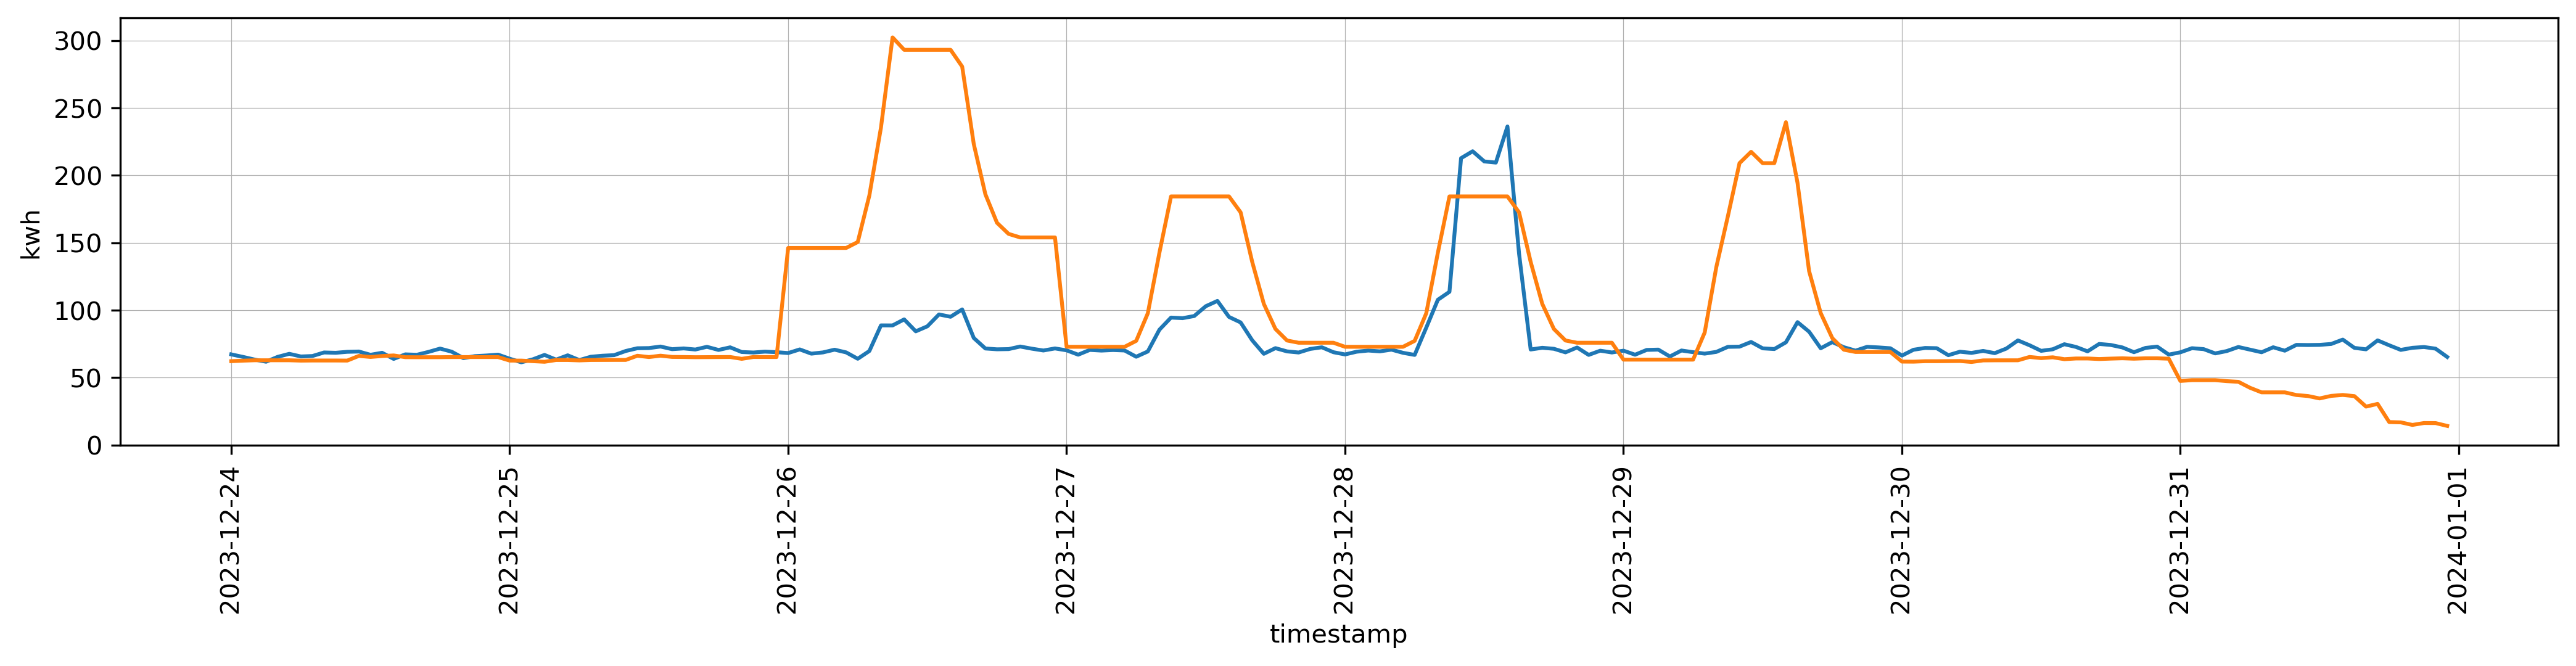

In [162]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_results, x='timestamp', y='kwh')
sns.lineplot(data=test_results, x='timestamp', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)